In [1]:
import numpy as np
import os
import random
import scipy
from scipy import signal
from numpy.fft import fft
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.initializers import he_normal

from sklearn.model_selection import train_test_split

import pandas as pd
import pickle

import seaborn as sns
sns.set(font='Yu Gothic')
import matplotlib.pyplot as plt
%matplotlib inline

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [35]:
def plot_confusion_matrix(test_y,pred_y,class_names,normalize=False, figsize=(16, 8)):
    cm = confusion_matrix(test_y,pred_y)
    # classes = class_names[unique_labels(test_y,pred_y)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    fig, ax = plt.subplots(figsize=figsize)
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=class_names,
           yticklabels=class_names,
           ylabel='True label\n',
           xlabel='\nPredicted label')
    fmt = '.2f' if normalize else 'd'
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j,
                    i,
                    format(cm[i, j], fmt),
                    ha="center",
                    va="center",
                    color="red", fontsize=16)
    fig.tight_layout()
    return ax

In [4]:
def load_npy(hold_position):
    mag = np.delete(np.load("../Output/train/train_" + hold_position + "/train_" + hold_position + "_glo_mag_norm_spectram.npy"), 120845, 0)[:, :40, :]
    return mag

In [9]:
train_Label = np.delete(np.load("../Data/センサ別npyファイル/train/train_Bag/train_Bag_LAbel.npy")[:, 0], 120845, 0).reshape([-1, 1])
train_Label.shape

(195490, 1)

In [5]:
train_Bag = load_npy("Bag")
train_Hips = load_npy("Hips")
train_Torso = load_npy("Torso")
train_Hand = load_npy("Hand")

train_Hand.shape

(195491, 40, 25)

In [6]:
def load_npy(hold_position):
    mag = np.load("../Output/validation/validation_" + hold_position + "/validation_" + hold_position + "_glo_mag_norm_spectram.npy")[:, :40, :]
    return mag

In [11]:
val_Label = np.load("../Data/センサ別npyファイル/validation/validation_Bag/validation_Bag_Label.npy")[:, 0].reshape([-1, 1])
val_Label.shape

(28685, 1)

In [7]:
val_Bag = load_npy("Bag")
val_Hips = load_npy("Hips")
val_Torso = load_npy("Torso")
val_Hand = load_npy("Hand")

val_Hand.shape

(28685, 40, 25)

In [24]:
X_train = np.concatenate([train_Bag, train_Hips, train_Torso, train_Hand], axis=0)
Y_train = np.concatenate([train_Label, train_Label, train_Label, train_Label], axis=0)

X_train.shape, Y_train.shape

((781960, 40, 25), (781960, 1))

In [25]:
X_test = np.concatenate([val_Bag, val_Hips, val_Torso, val_Hand], axis=0)
Y_test = np.concatenate([val_Label, val_Label, val_Label, val_Label], axis=0)

X_test.shape, Y_test.shape

((114740, 40, 25), (114740, 1))

In [26]:
X_train = X_train.reshape([-1, 40, 25, 1])
X_test = X_test.reshape([-1, 40, 25, 1])

X_train = X_train[(Y_train.reshape([-1]) == 1) | (Y_train.reshape([-1]) >= 5)]
Y_train = Y_train[(Y_train.reshape([-1]) == 1) | (Y_train.reshape([-1]) >= 5)]

X_test = X_test[(Y_test.reshape([-1]) == 1) | (Y_test.reshape([-1]) >= 5)]
Y_test = Y_test[(Y_test.reshape([-1]) == 1) | (Y_test.reshape([-1]) >= 5)]

X_train.shape, X_test.shape

((557016, 40, 25, 1), (82176, 40, 25, 1))

In [27]:
Y_train[Y_train.reshape([-1]) == 1] = 0
Y_test[Y_test.reshape([-1]) == 1] = 0

Y_train[Y_train.reshape([-1]) >= 5] = Y_train[Y_train.reshape([-1]) >= 5] - 4
Y_test[Y_test.reshape([-1]) >= 5] = Y_test[Y_test.reshape([-1]) >= 5] - 4

np.unique(Y_train), np.unique(Y_test)

(array([0., 1., 2., 3., 4.]), array([0., 1., 2., 3., 4.]))

In [28]:
x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train, test_size=0.3, shuffle=False)

x_train.shape, x_test.shape

((389911, 40, 25, 1), (167105, 40, 25, 1))

In [29]:
model = tf.keras.Sequential()
# model.add(layers.Flatten())
model.add(layers.Conv2D(64, (3, 3), padding='valid', activation='relu', input_shape=(x_train.shape[1], x_train.shape[2], 1), kernel_initializer=he_normal()))
model.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(5, activation='softmax'))
model.compile(optimizer=tf.keras.optimizers.Adam(0.01),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [30]:
cp_cb = tf.keras.callbacks.ModelCheckpoint(filepath="../Output/CheckPoint/mag_norm/model_{epoch:02d}-{loss:.2f}-{accuracy:.2f}-{val_loss:.2f}-{val_accuracy:.2f}.hdf5", 
                                           monitor='val_loss', verbose=0, save_best_only=True, mode='auto')
es_cb = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=30, verbose=0, mode='auto')
history = model.fit(x_train, y_train, epochs=256, batch_size=3072, validation_data=(x_test, y_test), callbacks=[cp_cb, es_cb])

Train on 389911 samples, validate on 167105 samples
Epoch 1/256
389911/389911 [==============================] - 46s 117us/sample - loss: 1.2696 - accuracy: 0.4384 - val_loss: 1.5006 - val_accuracy: 0.3970
Epoch 2/256
389911/389911 [==============================] - 25s 63us/sample - loss: 1.1988 - accuracy: 0.4766 - val_loss: 1.3731 - val_accuracy: 0.3919
Epoch 3/256
389911/389911 [==============================] - 25s 63us/sample - loss: 1.1803 - accuracy: 0.4867 - val_loss: 1.3815 - val_accuracy: 0.3787
Epoch 4/256
389911/389911 [==============================] - 25s 65us/sample - loss: 1.1692 - accuracy: 0.4938 - val_loss: 1.3547 - val_accuracy: 0.4174
Epoch 5/256
389911/389911 [==============================] - 25s 63us/sample - loss: 1.1611 - accuracy: 0.4983 - val_loss: 1.4348 - val_accuracy: 0.4289
Epoch 6/256
389911/389911 [==============================] - 25s 63us/sample - loss: 1.1552 - accuracy: 0.5014 - val_loss: 1.3724 - val_accuracy: 0.4240
Epoch 7/256
389911/389911 [==

In [31]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 38, 23, 64)        640       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 38, 23, 32)        18464     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 19, 11, 32)        0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 19, 11, 32)        128       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 19, 11, 64)        18496     
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 19, 11, 32)        18464     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 9, 5, 32)         

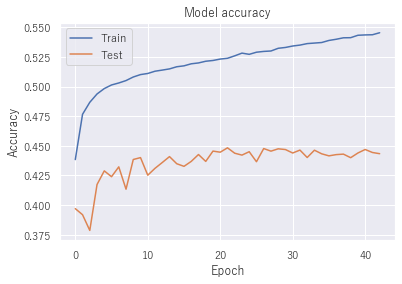

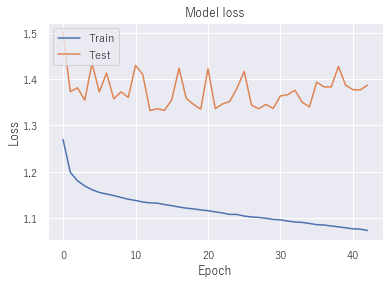

In [33]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
# plt.ylim((0, 3.5))
plt.show()

In [34]:
model = tf.keras.models.load_model("../Output/CheckPoint/mag_norm/model_13-1.13-0.51-1.33-0.44.hdf5")

0.481

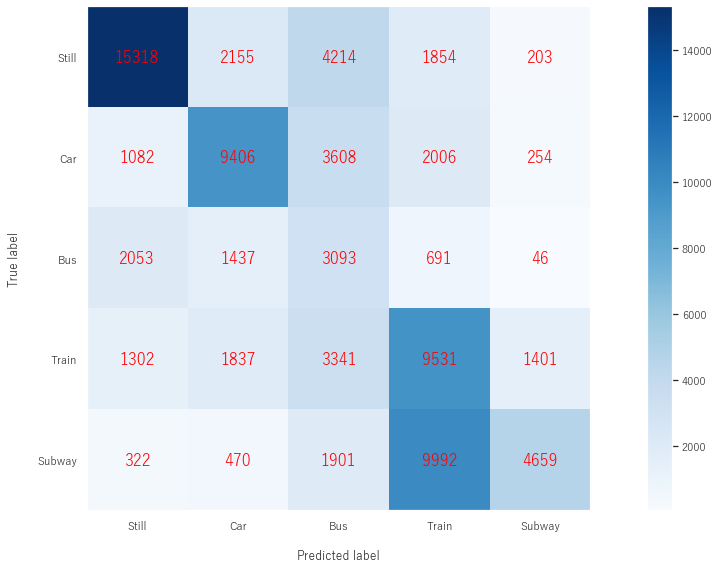

In [37]:
# class_names = ['Still', 'Walking', 'Run', 'Bike', 'Car', 'Bus', 'Train', 'Subway']
class_names = ["Still", "Car", "Bus", "Train", "Subway"]
predict = model.predict_classes(X_test)
plot_confusion_matrix(Y_test, predict, class_names, False, (16, 8))
plt.grid(False)
f1_macro = f1_score(Y_test, predict, average='macro')
round(f1_macro, 3)